## DNPAO Obesity Maps
- Author: Pat Zhang
- Purpose: Python script to create annual obesity maps by state and race

### Import libraries and reference data

## Workflow

Instructions:
- Set data and shape paths (local)
- Run all cells in this jupyter notebook
- Scroll down to "Create Map" section and select race. (Map may take a few seconds to synthesize)
- After map appears, left click and save as image on local device

Note: User may need to merge overall data from another workbook.

In [1]:
## User input

## Set map figure title
map_title = "Prevalence of BMI >= 30 (2022)"

## Set shapefiles and prevalence data path
data_path = 'C:/Users/rvy3/OneDrive - CDC/CDC_Work/DNPAO/Python_Obesity_Maps/Obesity_Prevalence_Data/BRFSS 2020-2022_Obesity prevalence by race.ethnicity and states_23.09.01.xlsx'
shape_path = 'C:/Users/rvy3/OneDrive - CDC/CDC_Work/DNPAO/Python_Obesity_Maps/Shapefiles/cb_2018_us_state_500k.shp'

In [2]:
## Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib import patheffects
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import clear_output

### Define lists and dictionaries
- These should stay constant, changes will have downstream impacts

In [3]:
## Read in shapefile using geopandas
shape = gpd.read_file(shape_path)

## Define projections.  
##     Use cont_projection for contiguous US
cont_projection = "ESRI:102003"
##     Use excep_projection for exception states 
excep_projection = "EPSG:4326"

## List all state/territories in obesity map
State_names = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']
# 54 unique values

## Create dictionary.  Key = Race; Dataframe = excel sheet with each dataframe by race
race_df_dict = {"White": pd.read_excel(data_path, skiprows=2, sheet_name='white'),
                "Black": pd.read_excel(data_path, skiprows=2, sheet_name='black'),
                "Hispanic": pd.read_excel(data_path, skiprows=2, sheet_name='hispanic'),
                "Asian":pd.read_excel(data_path, skiprows=2, sheet_name='asian'),
                "American Indian & Alaska Native": pd.read_excel(data_path, skiprows=2, sheet_name='AI AN'),
                "overall": pd.read_excel(data_path, skiprows=2, sheet_name='overall'),}

## List race text
list_race_text = list(race_df_dict.keys())

## Define prevalence number bins
prev_num_bins = [-np.inf, 0.0001, 19.95, 24.95, 29.95, 34.95, 39.95, 44.95, 49.95, 100]

## Create color dictionary based on prevalence categories
color_dict = {'Insufficient data*':'#FFFFFF',
            '<20%':'#86CC4E',
            '20%-<25%':'#56A81E',
            '25%-<30%':'#F4E700',
            '30%-<35%':'#FA6C1E',
            '35%-<40%':'#E7270E',
            '40%-<45%':'#AD0805',
            '45%-<50%':'#600005',
            '50%+':'#2C0000'}

## Create list of prevalence categories
list_prev_cats = list(color_dict.keys())

## Create list of prevalence categories in order on legend (Insufficient data* at bottom)
list_prev_cats_patch = list_prev_cats

x = len(list_prev_cats_patch)
list_prev_cats_patch.remove('Insufficient data*')
list_prev_cats_patch.insert(x-1, 'Insufficient data*')

### Data Cleaning and Prep
- For loop cleans and merges data

In [4]:
for i in list_race_text:
    ## Replace:
    ##    - insufficient data* with 0
    ##    - Virgin islands with official name on shapefile
    race_df_dict[i] = race_df_dict[i].replace(to_replace=["Insufficient data*", "Virgin Islands"],
                                    value=["0", "United States Virgin Islands"])
    
    ## Remove rows with NaN
    race_df_dict[i] = race_df_dict[i].dropna(axis='rows')
    # This drops any extra rows that don't include data.
    # States can have 'Insufficient data*', but not missing
    
    ## Convert prevalence estimates from object to float numeric
    race_df_dict[i]['Prevalence'] = race_df_dict[i]['Prevalence'].astype('float')
    
    ## Drop 95% CI column (unused)
    race_df_dict[i] = race_df_dict[i].drop(columns="95% CI")
    
    ### Bin into categories and add to dataset
    ## Prevalence categories
    prev_category = pd.cut(race_df_dict[i]['Prevalence'],
                           bins = prev_num_bins,
                           labels = color_dict.keys(),
                           right = False)
    race_df_dict[i].insert(2,'prev_cat', prev_category)

    ## Prevalence category colors
    race_df_dict[i]['prev_cat_color'] = race_df_dict[i]['prev_cat'].map(color_dict)
    
    ## Insert race variable
    race_df_dict[i].insert(4, 'race', i)
    
    ## Join shapefile with data
    race_df_dict[i] = pd.merge(
        left = shape,
        right = race_df_dict[i],
        left_on = 'NAME',
        right_on = 'State',
        how = 'left'
    ).set_index('STUSPS', drop = False)
    
    ## Drop states that are in shapefile but not tracked on obesity map
    race_df_dict[i] = race_df_dict[i].dropna(subset=['prev_cat_color'])

## Map Function

In [5]:
race_df_dict["White"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,State,Prevalence,prev_cat,prev_cat_color,race
STUSPS,,,,,,,,,,,,,,,
MS,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",Mississippi,34.822372,30%-<35%,#FA6C1E,White
NC,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",North Carolina,31.300304,30%-<35%,#FA6C1E,White
OK,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",Oklahoma,37.366457,35%-<40%,#E7270E,White
VA,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",Virginia,32.775754,30%-<35%,#FA6C1E,White
WV,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",West Virginia,40.315204,40%-<45%,#AD0805,White
LA,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",Louisiana,36.130118,35%-<40%,#E7270E,White
MI,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",Michigan,34.259073,30%-<35%,#FA6C1E,White
MA,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",Massachusetts,26.119397,25%-<30%,#F4E700,White
ID,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",Idaho,31.408184,30%-<35%,#FA6C1E,White


In [6]:
## Ignore color column warning
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

In [7]:
## Create map function

def create_map(race_var):

    df = race_df_dict[race_var].to_crs(cont_projection)

    ###################################################################################
    ## Plot setup

    ## create an axis with inset plots
    fig, continental_ax = plt.subplots(figsize=(20, 10))
    AK_ax = continental_ax.inset_axes([.0, .07, .28, .28]) # [x0, y0, width, height]
    HI_ax = continental_ax.inset_axes([.24, .07, .15, .19])
    GU_ax = continental_ax.inset_axes([.50, .07, .1, .15])
    VI_ax = continental_ax.inset_axes([.61, .04, .1, .25])
    PR_ax = continental_ax.inset_axes([.72, .06, .125, .1])
    DC_ax = continental_ax.inset_axes([.95, .53, .075, .075])
    RI_ax = continental_ax.inset_axes([.95, .65, .075, .075])

    ## Define dictionary for exception states to ax
    excep_state_ax_dict = {'AK':AK_ax,
                           'HI':HI_ax,
                           'GU':GU_ax,
                           'VI':VI_ax,
                           'PR':PR_ax,
                           'DC':DC_ax,
                           'RI':RI_ax}

    ## Define list of exception states
    excep_state_ax_list = list(excep_state_ax_dict.keys())

    ###################################################################################
    ####### Define where ax will show up on figure

    ####### Continental US Projection = ESRI:102003
    ## Set bounds to fit desired areas in each plot
    continental_ax.set_ylim(-2000000, 1800000) # Longtitude - Vertical
    continental_ax.set_xlim(-2500000, 2500000) # latitude - Horizontal

    ####### Exception State Projection = EPSG:4326
    AK_ax.set_ylim(51, 72)
    AK_ax.set_xlim(-180, -127)

    HI_ax.set_ylim(18.8, 22.5)
    HI_ax.set_xlim(-160, -154.6)

    GU_ax.set_ylim(13.2, 13.7)
    GU_ax.set_xlim(144.6, 145)

    VI_ax.set_ylim(17.5, 18.5)
    VI_ax.set_xlim(-65.2, -64.5)

    PR_ax.set_ylim(17.5, 19)
    PR_ax.set_xlim(-67.5, -65.5)

    DC_ax.set_ylim(38.79, 39)
    DC_ax.set_xlim(-77.15, -76.85)

    RI_ax.set_ylim(41.3, 42.1)
    RI_ax.set_xlim(-72, -71.1)

    ###################################################################################

    ## Add hatches
    # NOTE:  This must be done before adding color data.  
    #        Map looks distorted for some reason if hatch added after color data

    ## Steps
    ## 1. Define hatch attributes as dictionary.
    ##     keys: [Insufficient data*, <20%, 50%+]
    ##     value pairs: states that are keys, hatch color, hatches
    hatch_atr_dict = {"Insufficient data*": [list(df.loc[df.prev_cat == "Insufficient data*"].index), "black", " "],
                      "<20%": [list(df.loc[df.prev_cat == "<20%"].index), "black", ".."],
                      "50%+": [list(df.loc[df.prev_cat == "50%+"].index), "white", ".."]}

    ## 2. Apply the hatch logic for each prevalence cat

    ## 2a. Continental states - use for loop
    for hatch_dict_key in hatch_atr_dict:
        for states in hatch_atr_dict[hatch_dict_key][0]:
            ## Insufficient data
            df.loc[[states]].plot(ax = continental_ax, color = "#FF000000", linewidth = 0,
                            edgecolor=hatch_atr_dict[hatch_dict_key][1], hatch = hatch_atr_dict[hatch_dict_key][2], zorder=2)
    # Good this works

    ## 2b. Exception states - use if statement
    ## Define function for exception states
    def excep_state_hatch_func(state_code, ax_name):
    #     if state_code prevalence category in "Insufficient data*":
        if state_code in hatch_atr_dict["Insufficient data*"][0]:
            df.loc[[state_code]].plot(ax = ax_name, color = "#FF000000", linewidth = 0,
                                      edgecolor=hatch_atr_dict["Insufficient data*"][1],
                                      hatch = hatch_atr_dict["Insufficient data*"][2],
                                      zorder=2)
    #     if state_code prevalence category in "<20%":
        elif state_code in hatch_atr_dict["<20%"][0]:
            df.loc[[state_code]].plot(ax = ax_name, color = "#FF000000", linewidth = 0,
                                      edgecolor=hatch_atr_dict["<20%"][1], 
                                      hatch = hatch_atr_dict["<20%"][2],
                                      zorder=2)
    #     if state_code prevalence category in "50%+":
        elif state_code in hatch_atr_dict["50%+"][0]:
            df.loc[[state_code]].plot(ax = ax_name, color = "#FF000000", linewidth = 0,
                                      edgecolor=hatch_atr_dict["50%+"][1], 
                                      hatch = hatch_atr_dict["50%+"][2],
                                      zorder=2)

    ## Run exeption state hatch function
    df = df.to_crs(excep_projection)
    for state_code in excep_state_ax_dict:
        excep_state_hatch_func(state_code,excep_state_ax_dict[state_code])
    df = df.to_crs(cont_projection)
    for state_code in excep_state_ax_dict:
        excep_state_hatch_func(state_code,excep_state_ax_dict[state_code])
    ###################################################################################

    ## Use geopandas to plot prevalence category colors
    df.plot(column="prev_cat", ax=continental_ax,
            color = df.prev_cat_color,
            edgecolor = 'black', linewidth = .35)

    df = df.to_crs(excep_projection)

    df.loc[['AK']].plot(column="prev_cat", ax=AK_ax, 
            color = df.loc[['AK']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['HI']].plot(column="prev_cat", ax=HI_ax, 
            color = df.loc[['HI']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['GU']].plot(column="prev_cat", ax=GU_ax, 
            color = df.loc[['GU']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['VI']].plot(column="prev_cat", ax=VI_ax, 
            color = df.loc[['VI']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['PR']].plot(column="prev_cat", ax=PR_ax, 
            color = df.loc[['PR']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['DC']].plot(column="prev_cat", ax=DC_ax, 
            color = df.loc[['DC']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)
    df.loc[['RI']].plot(column="prev_cat", ax=RI_ax, 
            color = df.loc[['RI']].prev_cat_color,
            edgecolor = 'black', linewidth = .35)

    df = df.to_crs(cont_projection)

    ###################################################################################

    ## Set titles
#     continental_ax.xaxis.set_label_position('top')
#     continental_ax.set_title(map_title, size = 30, weight = 'bold', y = .95)  
#     continental_ax.set_xlabel('Race: '+df.race[1], size = 24, y = .92, labelpad = -50)

    ## For loop - formatting
    for ax in [RI_ax, DC_ax, continental_ax, AK_ax, HI_ax, GU_ax, VI_ax, PR_ax]:

        ## Remove ticks
        ax.set_yticks([])
        ax.set_xticks([])

        ## Remove edges around the plot
        for edge in ['right', 'bottom', 'top', 'left']:
            ax.spines[edge].set_visible(False)

        ## Add state annotations
        ##    Filter out small states that are pulled out [RI,DC]
        ##    Filter out states where centroid doesn't look right [MI, LA, FL, HI, PR]

        ## Start with continental US,    
        if ax == continental_ax:

            ## Plot annotations except:
            ##    Filter out small states that are pulled out [RI,DC]
            ##    Filter out states where centroid doesn't look right [FL, MI, LA]
            df[~df['NAME'].isin(['Rhode Island', 'District of Columbia', 'Florida', 'Michigan', 'Louisiana'])].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                xy=x.geometry.centroid.coords[0], ha='center', size=10, color='black',
                path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)

            ### Shifting annotations.  Manual process
            ###      Use the xytext option to shift text

            ## Shift Florida annotation        
            df[df.STUSPS == "FL"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(10, 0), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)

            ## Shift Michigan annotation         
            df[df.STUSPS == "MI"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(5, -20), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)

            ## Shift Louisiana annotation        
            df[df.STUSPS == "LA"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(-7, 0), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)
            
        ## After continental US change annotations for exception states
        else:
            df = df.to_crs(excep_projection)
            
            df[~df['NAME'].isin(['Hawaii','Puerto Rico','United States Virgin Islands'
                                ])].apply(lambda x: ax.annotate(text=x['STUSPS'], xy=x.geometry.centroid.coords[0],
                                           ha='center', size=10, color='black', 
                                           path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), 
                     axis=1)

            ## Shift Hawaii annotation        
            df[df.STUSPS == "HI"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(26, -26), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)

            ## Shift PR annotation         
            df[df.STUSPS == "PR"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(0, -4), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)
            
            ## Shift VI annotation         
            df[df.STUSPS == "VI"].apply(lambda x: ax.annotate(text=x['STUSPS'], 
                  xy=x.geometry.centroid.coords[0],  xytext=(5, -40), textcoords='offset pixels',                                                        
                   ha='center', size=10, color='black',
                  path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]), axis=1)
            
            df = df.to_crs(cont_projection)

    ###################################################################################

    ## Create legend manually using patches
    patch_list =[]
    for prev_cat in list_prev_cats_patch:
        label = prev_cat
        color = color_dict[prev_cat]

        # If prev_cat has hatch then 
        if prev_cat in hatch_atr_dict.keys():
            patch_list.append(patches.Patch(facecolor=color,
                                            label=label, 
                                            linewidth=.75,
                                            edgecolor=hatch_atr_dict[prev_cat][1],
                                            hatch = hatch_atr_dict[prev_cat][2]
    #                                         edgecolor='black'  ### Can't use edgecolor twice
                                           ))
        else:
            patch_list.append(patches.Patch(facecolor=color, 
                                            label=label, 
                                            linewidth=.75, 
                                            edgecolor='black'))

    # Creates a legend with the list of patches above.
    continental_ax.legend(handles=patch_list, fontsize=13, loc='lower left',
            bbox_to_anchor = (.84, .13), frameon=False, labelspacing=.25, handleheight=1.35)
#     leg_title = continental_ax.get_legend()
#     leg_title.set_title("Prevalence Categories")
    
    ## Make hatch linewidth narrow to help with visibility
    plt.rcParams['hatch.linewidth'] = 1

    ###################################################################################

#     ## Add lines pointing to RI and DC

#     ## Define xy coordinates for left and right line points
#     RI_Line_l = [2050000,690000]  #[x,y]
#     RI_Line_r = [2290000,600000]
#     DC_Line_l = [1650000,320000]
#     DC_Line_r = [2290000,100000]

#     ## Organize RI and DC
#     RI_line_x_values = [RI_Line_l[0], RI_Line_r[0]]
#     RI_line_y_values = [RI_Line_l[1], RI_Line_r[1]]

#     DC_line_x_values = [DC_Line_l[0], DC_Line_r[0]]
#     DC_line_y_values = [DC_Line_l[1], DC_Line_r[1]]

#     ## Plot lines
#     plt.plot(RI_line_x_values, RI_line_y_values, linewidth = 1, linestyle = "-", color = "black", zorder=3)
#     plt.plot(DC_line_x_values, DC_line_y_values, linewidth = 1, linestyle = "-", color = "black", zorder=3)

## Create Map

Dropdown(description='Race:', index=5, options=('White', 'Black', 'Hispanic', 'Asian', 'American Indian & Alas…

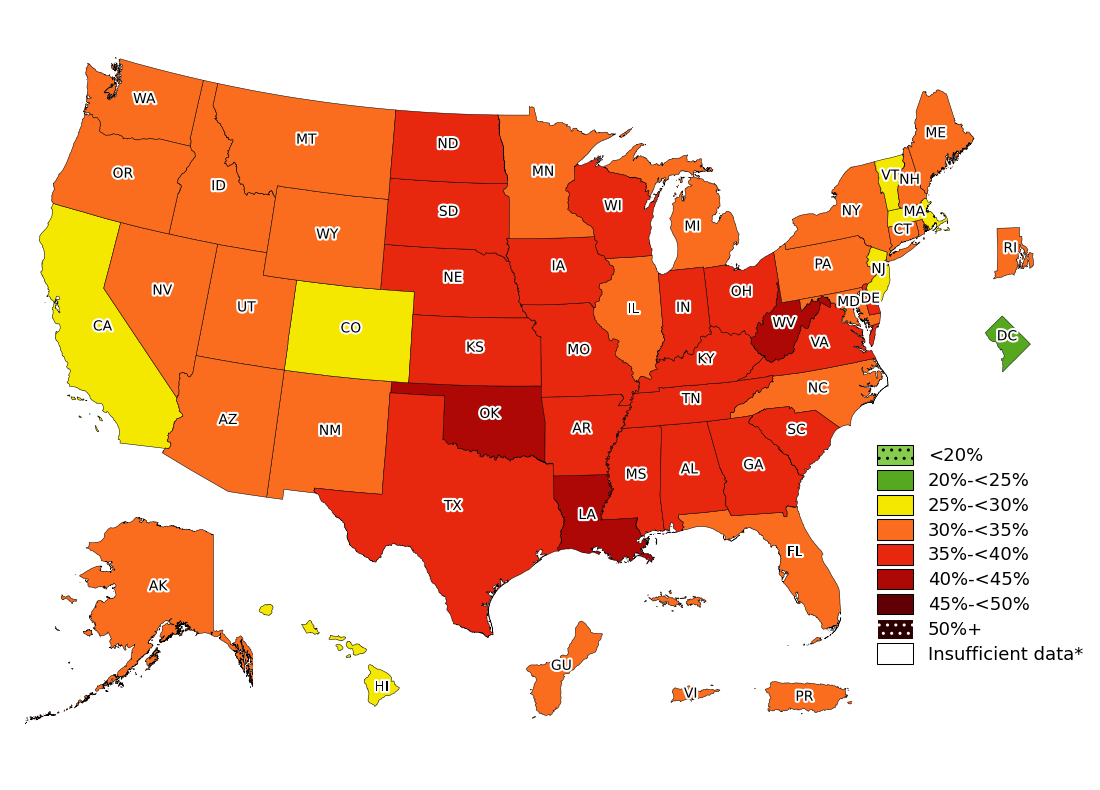

In [8]:
## Define drop down widget
drop_down = widgets.Dropdown(
    options=list_race_text,
    value=None,
    description='Race:',
    disabled=False,
)

## Define what happens when user changes Race drop_down
def dropdown_handler(change):
    global race_var
    
    race_var = change.new
    
    ## On change, clear previous output and insert waiting text
    clear_output(wait=False)
    print("Creating map for race = " + race_var + "...")
    clear_output(wait=True)
    
    ## Create map
    create_map(race_var)
    
    ## Display drop_down again
    display(drop_down)
    
drop_down.observe(dropdown_handler, names='value')
display(drop_down)

### QC

In [9]:
## State locator
race_df_dict["White"].loc[['HI']]
# OR
# race_df_dict["White"][race_df_dict["White"].STUSPS == "FL"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,State,Prevalence,prev_cat,prev_cat_color,race
STUSPS,,,,,,,,,,,,,,,
HI,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-156.06076 19.73055, -156.0566...",Hawaii,19.743247,<20%,#86CC4E,White


## Main points
- Compared with ArcGIS, creating maps has certain benefits
- The biggest benefit is automation. No more point and click, standard formulas/color schemes are applied to all states. Removes the risk of human error
- Data quality checks (ex: flags if state is completely missing)
- As a long term DMI solution, this method .  Python scripts integrate seamlessly with whatever cloud computing or data storage method, ArcGIS does not (point and click)
- Python map was designed to match previous ArcGIS maps
- Assuming data structure stays consistent, Anyone with python can run this script.  Just replace with new year data.

## Next Steps
- Are the hatching lines okay for insufficient data?
- Discuss maintenance down the line. 
- Any changes to race, states/territories, obesity categories, will require code updates
- Someone with python skills should be able to update code

## Future enhancements
- Add quality checks for data.
- Do we need an overall for all races combined?
- Python is one of the preferred languages for cloud computing.  A potential next step would be pulling obesity data directly from the source and running this program.

## Maintenance
- Workflow for updating prevalence categories
- Workflow for updating race
- Workflow for adding states/territories 

## PZ Enhancement Idea
- make a workflow to update legend if needed in future
- Make a workflow for updating states/terrs

## Troubleshooting

### Projection issues
- If error = "ProjError: x, y, z, and time must be same size", issue might be shapely library version
- To resolve:
1) Check shapely version in anaconda using following command in anaconda
    - conda list shapely
2) shapely version should be 1.8.4.  If version is 2.0.1, you must downgrade to version 1.8.4 for map projection to function correctly
3) To fix the problem, give the following command in anaconda
    - conda install shapely=1.8.4